## 1. Problem Description

**Diagnostics Prediction** is a project which aims to automatically predict diagnostics needed for a patient with certain anamnesis

The anamnesis is represented by a raw text file with doctor's notes about the patient, including his/her age, complaints described in free way, patient's history and so on. It is unstructured-different sections of one patient anamnesis may be absent in another's

The target labels are represented by the name of needed diagnostics procedure

**The value** on the solution might be found in helping a doctor to find the optimal solution for diagnostics order. Patient can save time and money, and doctor can serve a patient more efficiently on sparing time for unnecessary diagnostics. Moreover, in difficult cases the algorithm may help a doctor to find a diagnosis faster, which in some cases may be extremely valuable, up to saving lives

Theoretically, some regularities found by the algorithm may help medical researchers to find the idea of treating some diseases, based on their unobvious interconnections with some symptoms


## 2. Environment preparation, data import

In [1]:
!pip install imblearn

     |████████████████████████████████| 22.3 MB 4.4 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.3.1 requires numpy>=1.20.0, but you have numpy 1.19.5 which is incompatible.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.2 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 0.24.2 which is incompatible.


In [2]:
# Basic libraries

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
import random
import itertools
from collections import defaultdict

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from itertools import combinations
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from imblearn.under_sampling import NearMiss,RandomUnderSampler
from imblearn.over_sampling import SMOTE,ADASYN

# Models

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
import lightgbm as lgb

# Evaluation
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score,confusion_matrix,make_scorer
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
data = pd.read_csv('../input/medicaltranscriptions/mtsamples.csv')
print(data.shape)
data.head()

(4999, 6)


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


The dataset contains of several categorics, but we will need only **transcriptions** which is the anamnesis, and **medical_specialty**, which is the target diagnostics type

In [4]:
data = data[['transcription','medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index) # Dropping the rows which have transcription value as none

## 3. Data Review

Looking at some of the transcription values

In [5]:
data.iloc[0]['transcription']

'SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa was erythematous and swollen.  Only clear drainage was seen.  TMs were clear.,Neck:  Supple without adenopathy.,

Can you see the 7th line, it is **doest**, which should be **does**, maybe we need to apply some text lemmatization, pre-processings, to deal with it

Let us have a look at the target distribution

In [6]:
data['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Dentistry                          27
 Cosmetic / Plastic Surge

So, we can see that, the `Surgery` has the highest count of 1088, and the `Autopsy` has just 8 counts, so this is a case of Class-Imbalance dataset, so now we need to deal with this too!!

Let's do it, then!!

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Create a list of tokens for each sentence
tokenizer = RegexpTokenizer(r'\w+')
data['tokens'] = data['transcription'].apply(tokenizer.tokenize)

all_words = [word for tokens in data['tokens'] for word in tokens]
sentence_lengths  =[len(tokens) for tokens in data['tokens']]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" %(len(all_words),len(VOCAB)))
print("Max sentence length is %s"%max(sentence_lengths))

2420937 words total, with a vocabulary size of 28581
Max sentence length is 3114


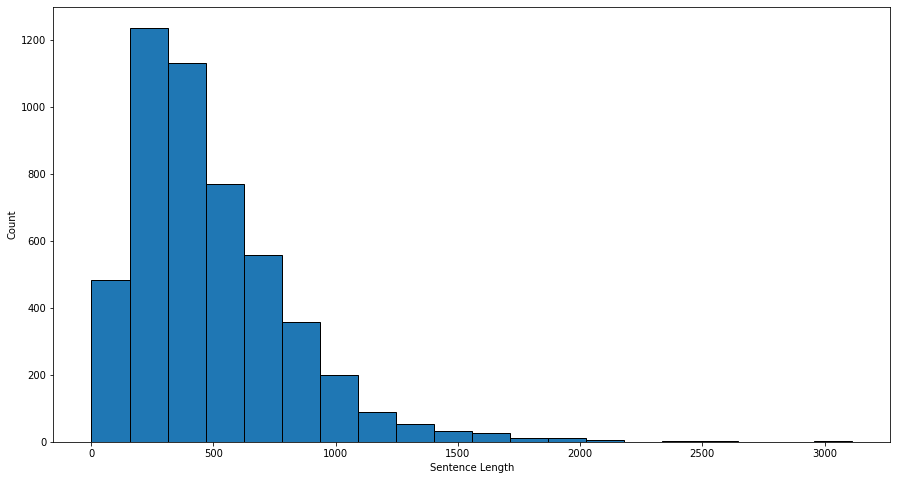

In [8]:
plt.figure(figsize=(15,8))
plt.hist(sentence_lengths,edgecolor = 'black',bins=20)
plt.xlabel("Sentence Length")
plt.ylabel("Count")
plt.show()

In [9]:
print(f"Median sentence length {np.median(sentence_lengths)}")
print(f"Mean sentence length {np.mean(sentence_lengths)}")

Median sentence length 421.5
Mean sentence length 487.5024164317358


From the above figures, we can see that the average median and mean values are long enough, means average sentence length is around 420 words, quite high!!!

## 4. Data transformation

In [10]:
# Text preparation

def basic_preprocessing(df):
    df_temp = df.copy(deep=True)
    
    df_temp = df_temp.rename(index = str,columns = {'transcription':'text'})
    df_temp.loc[:,'text'] = [text_prepare(x) for x in df_temp['text'].values]
    
    le = LabelEncoder()
    le.fit(df_temp['medical_specialty'])
    df_temp.loc[:,'class_label'] = le.transform(df_temp['medical_specialty'])
    tokenizer = RegexpTokenizer(r'\w+')
    df_temp['tokens'] = df_temp['text'].apply(tokenizer.tokenize)
    return df_temp

def text_prepare(text):
    
     '''
        This function will take an input as a text and then, preprocess it, 
        by removing the stopwords, special symbols and returns a text

        INPUT: text
        OUTPUT: text
     '''
     REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
     BAD_SYMBOLS_RE = re.compile('[^0-9a-z#+_]')
     STOPWORDS = set(stopwords.words('english'))
     text = text.lower()
     
     text = REPLACE_BY_SPACE_RE.sub('',text) # replace REPLACE_BY_SPACE_RE symbols by space in text
     text = BAD_SYMBOLS_RE.sub('',text) # delete symbols which are in BAD_SYMBOLS_RE from text
     words = text.split()
     
     i =0
     while i<len(words):
            if words[i] in STOPWORDS:
                words.pop(i)
            else:
                i+=1
     text = ' '.join(map(str,words))
     return text

def get_metrics(y_test,y_predicted):
    
    # getting the precision, recall, accuracy and f1 score
    precision = precision_score(y_test,y_predicted,average='weighted')
    recall = recall_score(y_test,y_predicted,average='weighted')
    f1 = f1_score(y_test,y_predicted,average='weighted')
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy,precision,recall,f1

## 4.1 Bag of words

So, in this, first of all we would be apply basic preprocessing function, which splits the words, removes unvaluable symbols and drop stopwords

In [11]:
def BOW(data):
    df_temp  =data.copy(deep = True)
    df_temp = basic_preprocessing(df_temp)
    
    count_vectorizer = CountVectorizer()
    count_vectorizer.fit(df_temp['text'])
    
    list_corpus = df_temp['text'].tolist()
    list_labels = df_temp['class_label'].tolist()
    
    X = count_vectorizer.transform(list_corpus)
    
    return X,list_labels

## 4.2 TF-IDF

For TD-IDF we use the same approach as above. The only difference is that, we would use TF-IDF vectorizer instead of count vectorizer. We will check 1-grams only and mix of 1 and 2 grams

In [12]:
def tfidf(data,ngrams = 1):
    
    df_temp = data.copy(deep=True)
    df_temp = basic_preprocessing(df_temp)
    
    tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,ngrams))
    tfidf_vectorizer.fit(df_temp['text'])
    
    list_corpus = df_temp['text'].tolist()
    list_labels = df_temp['class_label'].tolist()
    
    X =tfidf_vectorizer.transform(list_corpus)
    return X,list_labels

## 4.3 Word2Vec

Same Approach

In [13]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [14]:
def get_average_word2vec(tokens_list,vector,generate_missing=False,k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
        
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized,axis = 0)
    averaged = np.divide(summed,length)
    return averaged
def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [15]:
def w2v(data):
    df_temp = data.copy(deep=True)
    df_temp = basic_preprocessing(df_temp)
    
    embeddings = get_word2vec_embeddings(word2vec,df_temp)
    list_labels = df_temp['class_label'].tolist()
    return embeddings,list_labels

## 5. Baseline Modelling

As baseline model, we'' choose LogisticRegression as one of the most berstily one. Calculating the score metrics for 4 ways described before: Bag of words, TF-IDF with 1-gra, TF-IDF with 20gram, word2vec

In [16]:
folds = StratifiedKFold(n_splits =3,shuffle=True,random_state=40)
clf   = LogisticRegressionCV(cv=folds,solver ='saga',multi_class='multinomial',n_jobs=-1,random_state=40)

df_res = pd.DataFrame(columns = ['Preprocessing', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

# Bag of words approach
X,y = BOW(data)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=40)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
df_res = df_res.append({'Preprocessing': 'Bag of words',
                       'Precision': precision,
                       'Recall': recall,
                       'F1-score': f1,
                       'Accuracy': accuracy}, ignore_index = True)


# TF_IDF approach. 1-gram
X, y = tfidf(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
df_res = df_res.append({'Preprocessing': 'TF-IDF 1-gram',
                       'Precision': precision,
                       'Recall': recall,
                       'F1-score': f1,
                       'Accuracy': accuracy}, ignore_index =True)

# TF_IDF approach. 2-gram
X, y = tfidf(data, ngrams=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
df_res = df_res.append({'Preprocessing': 'TF-IDF 2-gram',
                       'Precision': precision,
                       'Recall': recall,
                       'F1-score': f1,
                       'Accuracy': accuracy}, ignore_index = True)
# Word2vec
X, y = w2v(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
df_res = df_res.append({'Preprocessing': 'Word2vec',
                       'Precision': precision,
                       'Recall': recall,
                       'F1-score': f1,
                       'Accuracy': accuracy}, ignore_index = True)

In [17]:
df_res

,Preprocessing,Precision,Recall,F1-score,Accuracy
0,Bag of words,0.050331,0.224346,0.082217,0.224346
1,TF-IDF 1-gram,0.050331,0.224346,0.082217,0.224346
2,TF-IDF 2-gram,0.050331,0.224346,0.082217,0.224346
3,Word2vec,0.065525,0.225352,0.086274,0.225352


## 6. Baseline Result analysis

As we can see, quality metrics vary a lot. So we need to choose the one we will be targeting on.

* Accuracy is not a good choice as due to very unbalanced class maximizing it will force alorithm to predict the major one;
* Precision indicates how much we can trust the algorithm when it predicts a certain class;
* Recall shows how many of the true labels of the class are predicted correctly by the algorithm;
* F1-score is the harmonic mean of precision and recall.

* As F1-score is the most balanced one of the metrics above, we will use it primarily, but still keeping an eye on others.

In [18]:
df_res

,Preprocessing,Precision,Recall,F1-score,Accuracy
0,Bag of words,0.050331,0.224346,0.082217,0.224346
1,TF-IDF 1-gram,0.050331,0.224346,0.082217,0.224346
2,TF-IDF 2-gram,0.050331,0.224346,0.082217,0.224346
3,Word2vec,0.065525,0.225352,0.086274,0.225352


The major classes are predicted quite well, but minor ones are confused a lot. Most possibly the reason is not only in unbalanceness of the classes, but in a very few absolute number of minor classes. Doubtfully the algorithm can gain some dependencies on 6 or 10 objects of one class.

So in order to make the model better we will get rid on the classes which are represented by less than 100 objects. For those we would need to get additional data.

## 7. Dataset Adjustment

Dropping objects with number of observations less than 100

In [19]:
counts  =data['medical_specialty'].value_counts()
data_100 = data[data['medical_specialty'].isin(counts[counts>100].index)]

In [20]:
data_100['labels'] = LabelEncoder().fit_transform(data_100['medical_specialty'])

In [21]:
data_100['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
Name: medical_specialty, dtype: int64

Imbalance is still high, but maybe this step should give us get better results

## 8. Selecting the best model

Now having the baseline odel on full dataset, we will try to improve it using adjusted dataset and three of the most suitable algorithms: Naive Bayes, Logistic Regression and LightGBM

## 8.1 Naive bayes

In [22]:
def training_naive(X_train_naive,X_test_naive,y_train_naive,y_test_naive,preproc):
    clf = MultinomialNB()
    clf.fit(X_train_naive,y_train_naive)
    
    res = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])
    
    y_pred = clf.predict(X_test_naive)
    
    f1 = f1_score(y_pred, y_test_naive, average = 'weighted')
    pres = precision_score(y_pred, y_test_naive, average = 'weighted')
    rec = recall_score(y_pred, y_test_naive, average = 'weighted')
    acc = accuracy_score(y_pred, y_test_naive)
    
    res = res.append({'Preprocessing': preproc, 'Model': 'Naive Bayes', 'Precision': pres, 
                     'Recall': rec, 'F1-score': f1, 'Accuracy': acc}, ignore_index = True)

    return res

## 8.2 Logistic Regression

In [23]:
def training_logreg(X_train_log,X_test_log,y_train_log,y_test_log,preproc):
    
    
    folds = StratifiedKFold(n_splits = 3,shuffle=True,random_state=40)
    clf = LogisticRegressionCV(cv= folds,solver='saga',multi_class='multinomial',n_jobs = -1)
    clf.fit(X_train_log,y_train_log)
    
    res = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])
    
    y_pred = clf.predict(X_test_log)
    
    f1 = f1_score(y_pred, y_test_log, average = 'weighted')
    pres = precision_score(y_pred, y_test_log, average = 'weighted')
    rec = recall_score(y_pred, y_test_log, average = 'weighted')
    acc = accuracy_score(y_pred, y_test_log)
    
    res = res.append({'Preprocessing': preproc, 'Model': 'Naive Bayes', 'Precision': pres, 
                     'Recall': rec, 'F1-score': f1, 'Accuracy': acc}, ignore_index = True)

    return res

## 8.3 LightGBM

For LightGBM first we need to make a pretune for the model to perform close to well

In [24]:
def training_lgbm(X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm, preproc,
                 n = 120, depth = 4, child = 2, bag = 0.9, feature = 0.9, l1 = 1, l = 0.01, w2v = False):
    
    if w2v:
        d_train = lgb.Dataset(X_train_lgbm, label=y_train_lgbm)
    else:
        d_train = lgb.Dataset(X_train_lgbm.astype(np.float32), label=y_train_lgbm)

    early_stop = 500
    verbose_eval = False
    num_rounds = n
    params = {
        'objective': 'multiclass',
        'num_class': len(set(y_train_lgbm)),
        'boosting': 'gbdt', 
        'metric': 'multi_logloss',
        'max_depth': depth, 
        'max_bin': 22, 
        'bagging_fraction': bag, 
        'feature_fraction': feature, 
        'min_child_samples': child, 
        'min_child_weight': 1, 
        'learning_rate': l,
        'verbosity': -1, 
        'data_random_seed': 17,
        'lambda_l1': l1}

    model = lgb.train(params, train_set = d_train, num_boost_round = num_rounds)

    y_pred_proba = model.predict(X_test_lgbm.astype(np.float32), num_iteration=model.best_iteration)
    y_pred = [np.argmax(x) for x in y_pred_proba]
    
    res = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])
        
    f1 = f1_score(y_pred, y_test_lgbm, average = 'weighted')
    pres = precision_score(y_pred, y_test_lgbm, average = 'weighted')
    rec = recall_score(y_pred, y_test_lgbm, average = 'weighted')
    acc = accuracy_score(y_pred, y_test_lgbm)
    
    res = res.append({'Preprocessing': preproc, 'Model': 'LightGBM', 'Precision': pres, 
                     'Recall': rec, 'F1-score': f1, 'Accuracy': acc}, ignore_index = True)

    return res

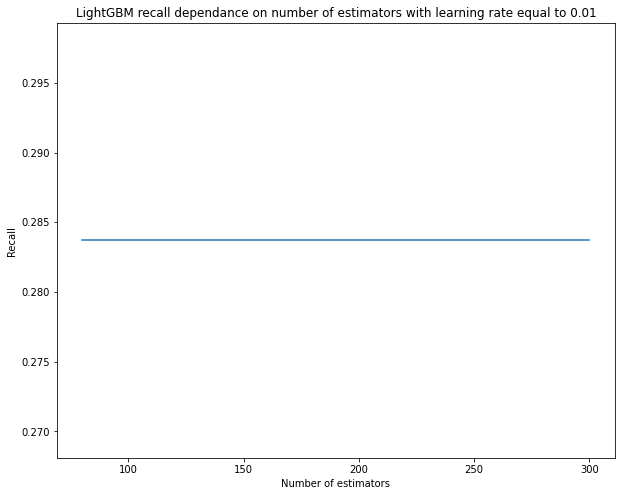

In [25]:
# Tune number of estimator at learning rate = 0.01

X, y = BOW(data_100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
ns = range(80, 301, 20)
recalls = []
for n in ns:
    recalls.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count', n = n, l = 0.01)['Recall'].values[0])
fig = plt.figure(figsize = (10, 8))
plt.plot(ns, recalls, label = 'Recall')
plt.xlabel('Number of estimators')
plt.ylabel('Recall')
plt.title('LightGBM recall dependance on number of estimators with learning rate equal to 0.01')
plt.show()

In [26]:
# Tune maximum tree depth and minimum elements in leaf
depths = range(2, 7, 2)
childs = range(2, 7, 2)
recalls = []
for depth in depths:
    for child in childs:
        recalls.append([training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-gram', 
                                     n = 120, l = 0.01, depth = depth, child = child)['Recall'].values[0], depth, child])
recalls.sort(reverse = True)
recalls[:3]

[[0.28369704749679076, 6, 6],
 [0.28369704749679076, 6, 4],
 [0.28369704749679076, 6, 2]]

In [27]:
data_100['labels'].value_counts()

10    1088
1      516
0      371
7      355
8      273
4      259
3      224
5      223
9      166
11     156
6      155
2      108
Name: labels, dtype: int64

In [28]:
for i in range(6,12):
    print(data_100[data_100['labels']==i]['medical_specialty'].values[0])

 Obstetrics / Gynecology
 Orthopedic
 Radiology
 SOAP / Chart / Progress Notes
 Surgery
 Urology


## 8.4 Calculations

In [29]:
# Dataframe for result evaluation
full_result = pd.DataFrame(columns = ['Preprocessing','Model','Precision','Recall','F1-score','Accuracy'])

# Testing count vectorizer

X,y = BOW(data_100)

X_train,X_test,y_train,y_test  =train_test_split(X,y,test_size = 0.2,random_state = 40)
full_result = full_result.append(training_logreg(X_train,X_test,y_train,y_test,'Count Vectorize'),ignore_index= True)
full_result = full_result.append(training_naive(X_train,X_test,y_train,y_test,'Count Vectorize'),ignore_index= True)

full_result = full_result.append(training_lgbm(X_train,X_test,y_train,y_test,'Count Vectorize'),ignore_index= True)


# Testing TF-IDF with 1-gram
X,y = tfidf(data_100,ngrams = 1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 40)
full_result = full_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
full_result = full_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)

# Testing TF-IDF with 2-gram
X,y = tfidf(data_100,ngrams = 2)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 40)
full_result = full_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)
full_result = full_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)

# Testing Word2vec

X, y = w2v(data_100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec'), ignore_index = True)

full_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Count Vectorize,Naive Bayes,1.000000,0.277279,0.434171,0.277279
1,Count Vectorize,Naive Bayes,0.468382,0.187420,0.263047,0.187420
2,Count Vectorize,LightGBM,1.000000,0.277279,0.434171,0.277279
3,TF-IDF 1-grams,Naive Bayes,0.832026,0.256739,0.392396,0.256739
4,TF-IDF 1-grams,Naive Bayes,1.000000,0.277279,0.434171,0.277279
5,TF-IDF 1-grams,LightGBM,1.000000,0.277279,0.434171,0.277279
6,TF-IDF 2-grams,Naive Bayes,0.810726,0.251605,0.384028,0.251605
7,TF-IDF 2-grams,Naive Bayes,1.000000,0.277279,0.434171,0.277279
8,TF-IDF 2-grams,LightGBM,1.000000,0.277279,0.434171,0.277279
9,Word2vec,Naive Bayes,0.971164,0.278562,0.429405,0.278562


## 9. Best model result analysis

The socres became higher. Let us take a look on confusion matrix for the best model

In [30]:
# Re-setup the algorithm

X,y = w2v(data_100)
X_train_log,X_test_log,y_train_log,y_test_log = train_test_split(X,y,test_size = 0.2,random_state = 40)

folds  =StratifiedKFold(n_splits = 3,shuffle=True,random_state  =40)
clf_w2v = LogisticRegressionCV(cv =folds,solver='saga',multi_class='multinomial',n_jobs = -1)
clf_w2v.fit(X_train_log,y_train_log)
y_pred = clf_w2v.predict(X_test_log)

In [31]:
import _pickle as cPickle
# save the classifier
with open('logistic_regression.pkl', 'wb') as fid:
    cPickle.dump(clf_w2v, fid)    

In [32]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix',cmap = plt.cm.winter):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis = 1)[:,np.newaxis]
        
    plt.imshow(cm,interpolation='nearest',cmap = cmap)
    plt.title(title,fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,fontsize = 10,rotation=90)
    plt.yticks(tick_marks,classes,fontsize = 10)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2
    
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),horizontalalignment = 'center',
                color = 'white' if cm[i,j]< thresh else 'black', fontsize = 12)
    plt.tight_layout()
    plt.ylabel("True label",fontsize = 20)
    plt.xlabel('Predicted label', fontsize = 20)
    
    return plt

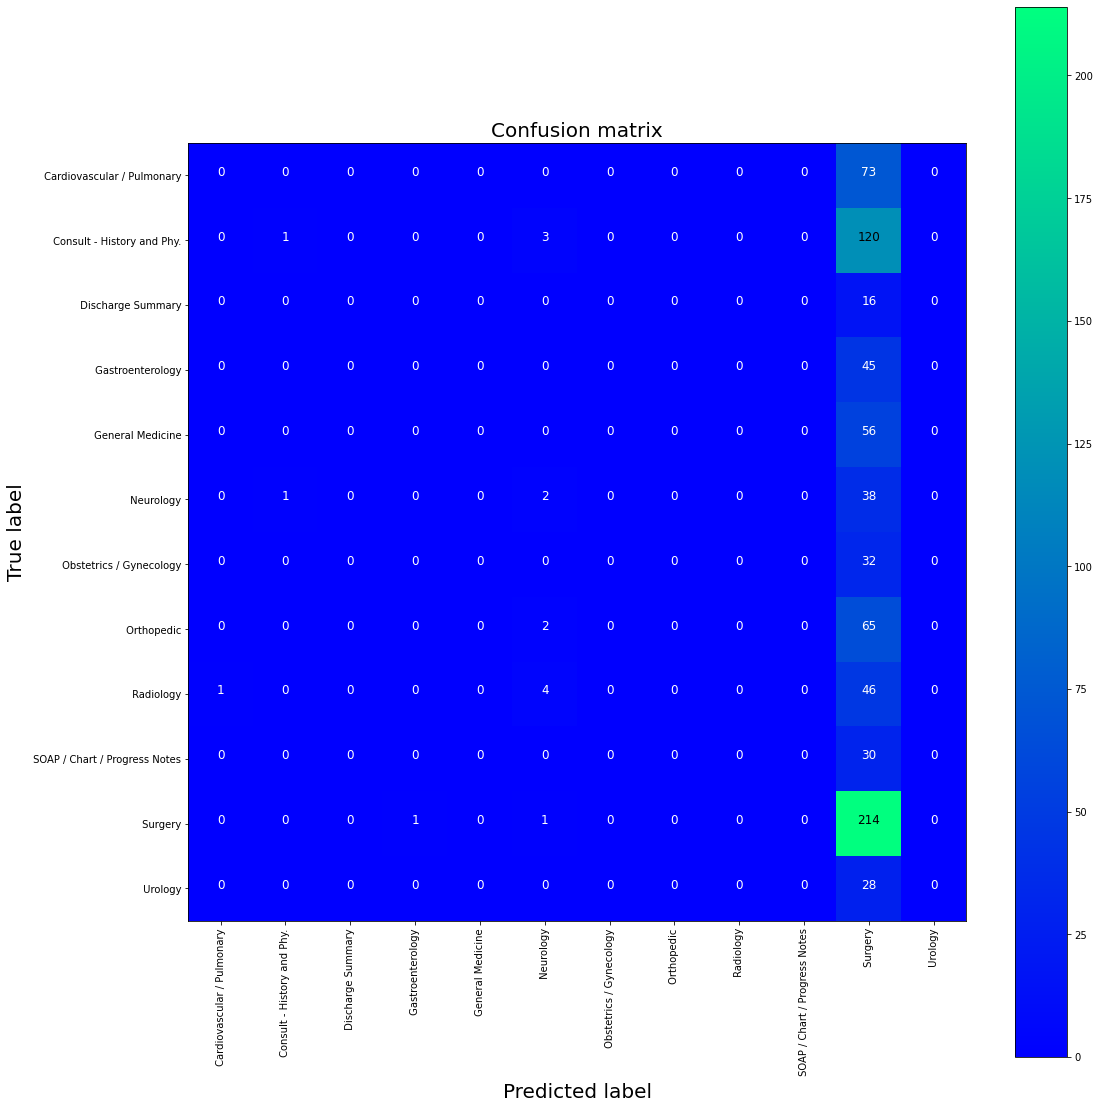

In [33]:
classes = [' Cardiovascular / Pulmonary', ' Consult - History and Phy.', ' Discharge Summary',
           ' Gastroenterology', ' General Medicine', ' Neurology', ' Obstetrics / Gynecology',
           ' Orthopedic', ' Radiology', ' SOAP / Chart / Progress Notes', ' Surgery', ' Urology']
cm = confusion_matrix(y_test_log, y_pred)
fig = plt.figure(figsize=(16, 16))
plot = plot_confusion_matrix(cm, classes=classes, normalize=False, 
                             title='Confusion matrix')
plt.show()

Another way to see how the model works is to manually watch at the most valuable and the least valuable words for the class.

In [34]:
vector_store = word2vec

def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens,vector_store,generate_missing=False,k =300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(CountVectorizer(),clf)

random.seed(40)

data_100_prep = basic_preprocessing(data_100)
list_corpus = data_100_prep['text'].tolist()
list_labels = data_100_prep['class_label'].tolist()

X_train_data,X_test_data,y_train_data,y_test_data = train_test_split(list_corpus,list_labels,test_size = 0.2,random_state = 40)

def get_statistical_explanation(test_set,sample_size,word2vec_pipeline,label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions
    
    

label_to_text = {
    0: ' Cardiovascular / Pulmonary',
    1: ' Consult - History and Phy.',
    2: ' Discharge Summary',
    3: ' Gastroenterology',
    4: ' General Medicine',
    5: ' Neurology',
    6: ' Obstetrics / Gynecology',
    7: ' Orthopedic',
    8: ' Radiology',
    9: ' SOAP / Chart / Progress Notes',
    10: ' Surgery',
    11: ' Urology'
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

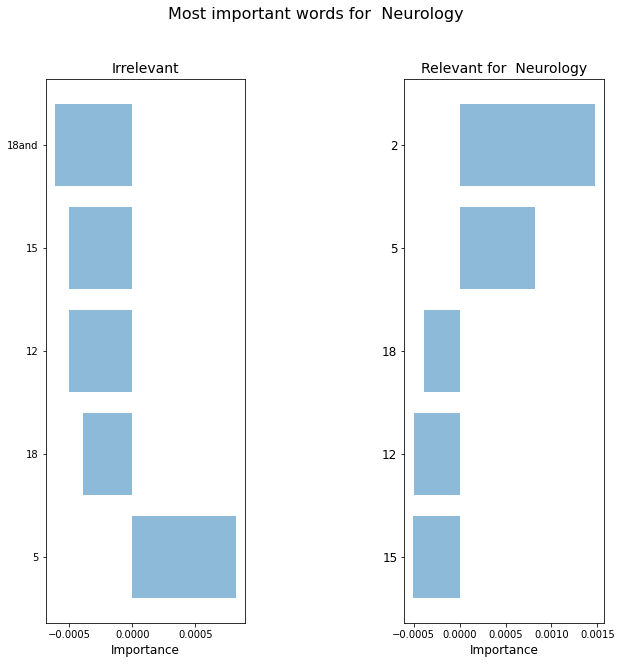

In [35]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=14)
    plt.yticks(y_pos, bottom_words, fontsize=10)
    plt.suptitle('Key words', fontsize=12)
    plt.xlabel('Importance', fontsize=12)
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title("Relevant for " + name, fontsize=14)
    plt.yticks(y_pos, top_words, fontsize=12)
    plt.suptitle(f"Most important words for {name}", fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

test_label = ' Neurology'
top_words = sorted_contributions[test_label]['supporters'][:5].index.tolist()
top_scores = sorted_contributions[test_label]['supporters'][:5].tolist()
bottom_words = sorted_contributions[test_label]['detractors'][:5].index.tolist()
bottom_scores = sorted_contributions[test_label]['detractors'][:5].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, test_label)

The words influence on relevancy seems to be truthful. Which can mean that we are going in the right direction

Let us continue with fixing the class imbalance

## 10. Retrieving sample unbalance problem

We can see that classes imbalance still prevents us from getting a better result

There are several ways to fight imbalance:
1. Undersampling
2. Oversampling
3. Use classifiers with class-weight adjustments

The last one we already did with logistic regression

Undersampling is cutting off some observations of the major classes to make them more comparable in count with the minor ones. Due to the amount of data we have, such approach might not be profitable, as we make the amount of data even smaller, which might affect model quality. But still we can try. Simple random drop of some observations share based on the assumption that dropping some samples will notaffect the distribution. Randomess of the samples pick and small amount of data doesn't ensure it. SO, we need to apply more complex methods

Oversampling, counterwise to undersampling, is adding more copies of observations from minor classes to straighted classes distribution. AS we are working with text data, doubling some samples will probably lead to overfitting on these samples. So, just like in the case of undersampling we will need more complex approach


## 10.1 Undersampling: Naive Approach

First we check how many observation the undersampling algorithm cuts off

In [36]:
naive_under_sample = RandomUnderSampler(sampling_strategy='majority')
X,y = BOW(data_100)
print(f"Initial set observations {X.shape[0]}")
print(f"Initial set target classes {len(set(y))}")
X,y = naive_under_sample.fit_resample(X,y)
print(f"Modified set observations {X.shape[0]}")
print(f"Modified set target classes {len(set(y))}")

Initial set observations 3894
Initial set target classes 12
Modified set observations 2914
Modified set target classes 12


In [37]:
# Dataframe for result evaluation

naive_result = pd.DataFrame(columns = ['Preprocessing','Model','Precision','Recall','F1-score','Accuracy'])
naive_under_sample = RandomUnderSampler(sampling_strategy = 'majority')

# Testing Count Vectorizer
X,y = BOW(data_100)
X,y = naive_under_sample.fit_resample(X,y)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 40)
naive_result = naive_result.append(training_naive(X_train,X_test,y_train,y_test,'Count Vectorize'),ignore_index=True)
naive_result = naive_result.append(training_logreg(X_train,X_test,y_train,y_test,'Count Vectorize'),ignore_index = True)
naive_result = naive_result.append(training_lgbm(X_train,X_test,y_train,y_test,'Count Vectorize'),ignore_index=True)

# Testing TF-IDF with 1-gram
X,y = tfidf(data_100,ngrams = 1)
X,y = naive_under_sample.fit_resample(X,y)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 40)
naive_result = naive_result.append(training_naive(X_train,X_test,y_train,y_test,'TF-IDF 1-grams'),ignore_index=True)
naive_result = naive_result.append(training_logreg(X_train,X_test,y_train,y_test,'TF-IDF 1-grams'),ignore_index = True)
naive_result = naive_result.append(training_lgbm(X_train,X_test,y_train,y_test,'TF-IDF 1-grams'),ignore_index=True)

# Testing Word2Vec

X,y = w2v(data_100)
X, y = naive_under_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
naive_result = naive_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec'), ignore_index = True)

In [38]:
naive_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Count Vectorize,Naive Bayes,0.357811,0.097770,0.149455,0.097770
1,Count Vectorize,Naive Bayes,1.000000,0.174957,0.297810,0.174957
2,Count Vectorize,LightGBM,1.000000,0.174957,0.297810,0.174957
3,TF-IDF 1-grams,Naive Bayes,0.389382,0.094340,0.151881,0.094340
4,TF-IDF 1-grams,Naive Bayes,1.000000,0.174957,0.297810,0.174957
5,TF-IDF 1-grams,LightGBM,1.000000,0.174957,0.297810,0.174957
6,Word2vec,Naive Bayes,0.982039,0.176672,0.295121,0.176672


One can see, that naive approach didn't make any significant gain in metrics. Recall became better in overall,but precision dropped. F1-score therefore slightly decreased.

As an alternative we will try NeaarMiss method

## 10.2 Undersampling NearMiss

How many observation the undersampling algorithm cuts off

In [39]:
near_under_sample = NearMiss(sampling_strategy='majority')
X,y = BOW(data_100)
print(f"Initial set observations {X.shape[0]}")
print(f"Initial set target classes {len(set(y))}")
X,y = near_under_sample.fit_resample(X,y)
print(f"Modified set observations {X.shape[0]}")
print(f"Modified set target classes {len(set(y))}")

Initial set observations 3894
Initial set target classes 12
Modified set observations 2914
Modified set target classes 12


In [40]:
# Dataframe for result evaluation

near_result = pd.DataFrame(columns = ['Preprocessing','Model','Precision','Recall','F1-score','Accuracy'])
near_under_sample = NearMiss(sampling_strategy='majority')

# Testing Count Vectorizer

X,y = BOW(data_100)
X,y = near_under_sample.fit_resample(X,y)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 40)
near_result=near_result.append(training_naive(X_train,X_test,y_train,y_test,"Count Vectorize"),ignore_index=True)
near_result = near_result.append(training_logreg(X_train,X_test,y_train,y_test,'Count Vectorize'),ignore_index = True)
near_result = near_result.append(training_lgbm(X_train,X_test,y_train,y_test,'Count Vectorize'),ignore_index=True)

# Testing TF-IDF with 1-gram

X,y = tfidf(data_100,ngrams = 1)
X,y = near_under_sample.fit_resample(X,y)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state= 40)
near_result = near_result.append(training_naive(X_train,X_test,y_train,y_test,'TF-IDF 1-grams'),ignore_index= True)
near_result = near_result.append(training_logreg(X_train,X_test,y_train,y_test,'TF-IDF 1-grams'),ignore_index=True)
near_result = near_result.append(training_lgbm(X_train,X_test,y_train,y_test,'TF-IDF 1-grams'),ignore_index=True)


# Testing Word2Vec

X,y = w2v(data_100)
X,y = near_under_sample.fit_resample(X,y)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 40)
near_result = near_result.append(training_logreg(X_train,X_test,y_train,y_test,'Word2Vec'),ignore_index=True)

In [41]:
near_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Count Vectorize,Naive Bayes,0.368555,0.097770,0.150226,0.097770
1,Count Vectorize,Naive Bayes,1.000000,0.174957,0.297810,0.174957
2,Count Vectorize,LightGBM,1.000000,0.174957,0.297810,0.174957
3,TF-IDF 1-grams,Naive Bayes,0.383833,0.094340,0.151454,0.094340
4,TF-IDF 1-grams,Naive Bayes,1.000000,0.174957,0.297810,0.174957
5,TF-IDF 1-grams,LightGBM,1.000000,0.174957,0.297810,0.174957
6,Word2Vec,Naive Bayes,0.982039,0.176672,0.295121,0.176672


NearMiss method gave almost the same result as naive approach. Which may treat like naive random undersampling have basically preserved the original distribution

## 10.3 Oversamplling SMOTE

For oversampling algorithm check how many observation the algorithm generates

In [42]:
smote_over_sample = SMOTE(sampling_strategy='minority')
X,y = BOW(data_100)
print(f"Initial set observations {X.shape[0]}")
print(f"Initial set target classes {len(set(y))}")
X,y = smote_over_sample.fit_resample(X,y)
print(f'Modified set observations {X.shape[0]}')
print(f'Modified set target classes {len(set(y))}')

Initial set observations 3894
Initial set target classes 12
Modified set observations 4874
Modified set target classes 12


In [43]:
# DataFrame for result evaluation

smote_result = pd.DataFrame(columns = ['Preprocessing','Model','Precision','Recall','F1-score','Accuracy'])
smote_over_sample = SMOTE(sampling_strategy='minority')

# Testing Count Vectorizer

X,y = BOW(data_100)
X,y = smote_over_sample.fit_resample(X,y)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 40)
smote_result = smote_result.append(training_naive(X_train,X_test,y_train,y_test,'Count Vectorize'),ignore_index=True)
smote_result = smote_result.append(training_logreg(X_train,X_test,y_train,y_test,'Count Vectorize'),ignore_index=True)
smote_result = smote_result.append(training_lgbm(X_train,X_test,y_train,y_test,'Count Vectorize'),ignore_index=True)


# Training TF-IDF with 1-gram

X,y = tfidf(data_100,ngrams = 1)
X,y = smote_over_sample.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
smote_result = smote_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
smote_result = smote_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
smote_result = smote_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)


# Testing Word2vec

X, y = w2v(data_100)
X, y = smote_over_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
smote_result = smote_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec'), ignore_index = True)

In [44]:
smote_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Count Vectorize,Naive Bayes,0.051076,0.021538,0.029592,0.021538
1,Count Vectorize,Naive Bayes,0.856746,0.226667,0.357437,0.226667
2,Count Vectorize,LightGBM,1.000000,0.224615,0.366834,0.224615
3,TF-IDF 1-grams,Naive Bayes,0.785291,0.225641,0.350064,0.225641
4,TF-IDF 1-grams,Naive Bayes,0.986971,0.427692,0.547707,0.427692
5,TF-IDF 1-grams,LightGBM,0.972884,0.410256,0.522465,0.410256
6,Word2vec,Naive Bayes,0.975548,0.218462,0.351947,0.218462


SMOTE generated oversampling procedur gave a huge leap in quality. More importantly - the quality have got gain in every direction, including noth precision and recall

## 10.4 Oversampling ADASYN

For oversampling algorithm check how many observation the algorithm generates

In [45]:
adasyn_over_sample = ADASYN(sampling_strategy='minority')
X, y = BOW(data_100)
print(f"Initial set observations {X.shape[0]}")
print(f"Initial set target classes {len(set(y))}")
X, y = adasyn_over_sample.fit_resample(X, y)
print(f"Modified set observations {X.shape[0]}")
print(f"Modified set target classes {len(set(y))}")

Initial set observations 3894
Initial set target classes 12
Modified set observations 4908
Modified set target classes 12


In [46]:
# DataFrame for result evaluation

adasyn_result = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

adasyn_over_sample = ADASYN(sampling_strategy='minority')

# Testing Count Vectorizer

X, y = BOW(data_100)
X, y = adasyn_over_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
adasyn_result = adasyn_result.append(training_naive(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
adasyn_result = adasyn_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
adasyn_result = adasyn_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)

# Testing TF-IDF with 1-gram

X, y = tfidf(data_100, ngrams = 1)
X, y = adasyn_over_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
adasyn_result = adasyn_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
adasyn_result = adasyn_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
adasyn_result = adasyn_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)

# Testing Word2vec

X, y = w2v(data_100)
X, y = adasyn_over_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
adasyn_result = adasyn_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec'), ignore_index = True)

In [47]:
adasyn_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Count Vectorize,Naive Bayes,0.776678,0.235234,0.361101,0.235234
1,Count Vectorize,Naive Bayes,0.820368,0.237271,0.367560,0.237271
2,Count Vectorize,LightGBM,1.000000,0.236253,0.382208,0.236253
3,TF-IDF 1-grams,Naive Bayes,0.780723,0.237271,0.363481,0.237271
4,TF-IDF 1-grams,Naive Bayes,0.984988,0.436864,0.556071,0.436864
5,TF-IDF 1-grams,LightGBM,0.977667,0.427699,0.540830,0.427699
6,Word2vec,Naive Bayes,0.974696,0.219938,0.351502,0.219938


ADASYN algorithm have shown approximately the same results as SMOTE. But still it's slightly worse. So we will keep to SMOTE.

## 11. Best model result analysis
Best model of all we have received is word2vec on SMOTE trained on Logistic Regression.

Let's look at its confusion matrix.

In [48]:
X, y = w2v(data_100)
X, y = smote_over_sample.fit_resample(X, y)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X, y, test_size=0.2, random_state=40)
clf_w2v_smote = LogisticRegressionCV(cv = folds, solver = 'saga', multi_class = 'multinomial', n_jobs = -1)
clf_w2v_smote.fit(X_train_smote, y_train_smote)
y_pred = clf_w2v_smote.predict(X_test_smote)

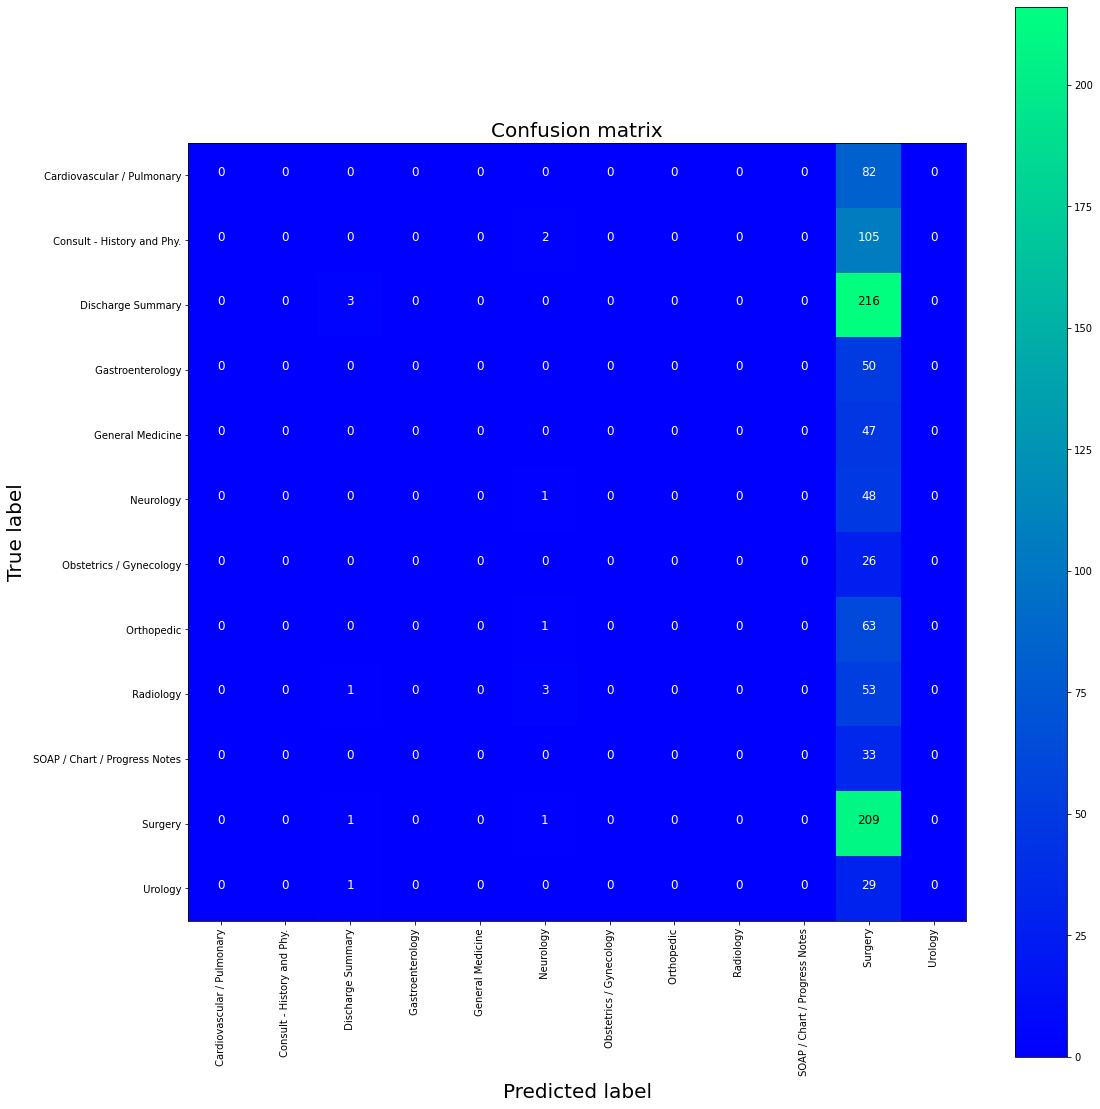

In [49]:
cm = confusion_matrix(y_test_smote, y_pred)
fig = plt.figure(figsize=(16, 16))
plot = plot_confusion_matrix(cm, classes=classes, normalize=False, 
                             title='Confusion matrix')
plt.show()


Result metrics for each class

In [50]:
final_metrics = pd.DataFrame({'Labels': range(12), 
                              'Recall': recall_score(y_pred, y_test_smote, average = None),
                             'Precision': precision_score(y_pred, y_test_smote, average = None),
                             'F1-score': f1_score(y_pred, y_test_smote, average = None)})
final_metrics['Labels'] = final_metrics['Labels'].replace(label_to_text)
final_metrics

,Labels,Recall,Precision,F1-score
0,Cardiovascular / Pulmonary,0.000000,0.000000,0.000000
1,Consult - History and Phy.,0.000000,0.000000,0.000000
2,Discharge Summary,0.500000,0.013699,0.026667
3,Gastroenterology,0.000000,0.000000,0.000000
4,General Medicine,0.000000,0.000000,0.000000
5,Neurology,0.125000,0.020408,0.035088
6,Obstetrics / Gynecology,0.000000,0.000000,0.000000
7,Orthopedic,0.000000,0.000000,0.000000
8,Radiology,0.000000,0.000000,0.000000
9,SOAP / Chart / Progress Notes,0.000000,0.000000,0.000000
